# HARPE(T) Dataset Exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.utils.data as data
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2 as cv
from PIL import Image

In [2]:
class H5Dataset(data.Dataset):

    def __init__(self, file_path):
        super(H5Dataset, self).__init__()
        h5_file = h5py.File(file_path + ".h5", 'r')
        # Extract filenames
        # TODO: filter filenames based on action
        path = "/".join(file_path.split('/')[:-1])
        path += "/images_" + file_path.split("_")[-1] + "/"
        filenames = h5_file.get('imgname')
        shape = filenames.shape
        filenames = np.array([chr(letter) for item in filenames for letter in item.astype(int)])
        self.data = np.array([np.array(Image.open(path + "".join(fname))) for fname in filenames.reshape(shape)])
        self.target = h5_file.get('part')
        
    def __getitem__(self, index):
        return (torch.from_numpy(self.data[index,:,:,:]).float(),
               torch.from_numpy(self.target[index,:,:,:]).float())
    
    def __len__(self):
        return self.data.shape[0]

In [3]:
path = "../../../datasets/VIP-HARPET/annot_"
Htest = H5Dataset(path + "test")
Htrain = H5Dataset(path + "train")
Hvalid = H5Dataset(path + "valid")

In [30]:
# Joint ordering: 18 joints total (including stick)
#
N = 18
pairs = [[0, 1],
         [1, 2],
         [2, 6],
         [3, 4],
         [3, 6],
         [4, 5],
         [6, 8],
         [8, 9],
         [12, 8],
         [10, 11],
         [11, 12],
         [10, 16],
         [16, 17],
         [13, 8],
         [13, 14],
         [14, 15]]

int64


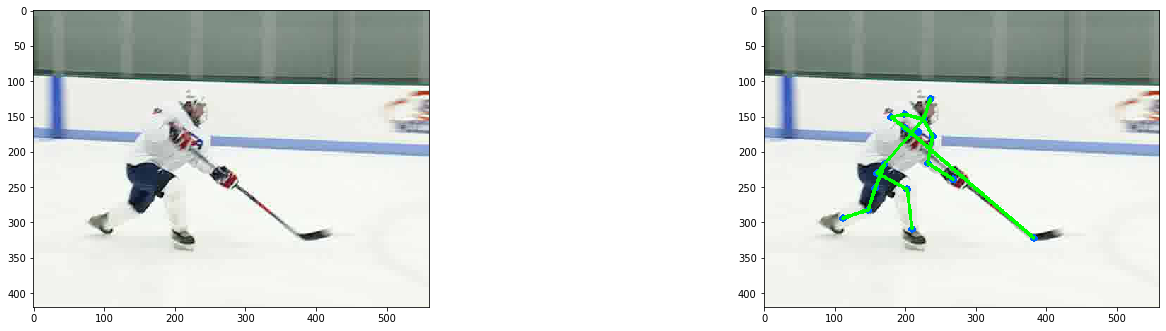

In [31]:
# Check training data
img, skeleton = Htrain.data[349], Htrain.target[349]
skeleton = np.rint(skeleton).astype(int)
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
img2 = img.copy()
# Draw joints
for joint in skeleton:
    img2 = cv.circle(img2, (joint[0], joint[1]), 5, (0, 100, 255), thickness=-1, lineType=cv.FILLED)
# Connect joints
for link in pairs:
    A = link[0]
    B = link[1]
    img2 = cv.line(img2, tuple(skeleton[A]), tuple(skeleton[B]), (0, 255, 0), 3)

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img2)